# Simumulated contextual effects for all neurons in a site

this is an attempt for a negative control in which there is no sparse contextual modulation, but rather a distributed one
this is acchieved by finding the mean probe response (context independent) and add simulated modulation.
This simulation is the mean gain for a given context across all neurons (thus equalizing the sparse representation).

The question that follows is whether dPCA will perform equally well or fail, and furthermore if the context and probe
discriminating projections are more or less alligned.

In [24]:
from src.data.load import set_name, load_with_parms
from src.root_path import  config_path
from src.metrics.reliability import signal_reliability
from src.data.rasters import load_site_formated_raster
from src.metrics.dprime import flip_dprimes
from src.metrics.consolidated_dprimes import _load_site_formated_raster as load_raster_real,\
    full_dPCA_dprimes as dPCA_dprimes_real, single_cell_dprimes as cell_dprimes_real
from src.metrics.consolidated_dprimes_simulation import _load_site_formated_raster as load_raster_sim,\
    homogenize_cxt_modulation as sim_ctx, full_dPCA_dprimes as dPCA_dprimes_sim, single_cell_dprimes as cell_dprimes_sim

from src.data.dPCA import format_raster, _cpp_dPCA
from src.visualization.fancy_plots import _raster, unit_line, savefig


import itertools as itt
import numpy as np
import pandas as pd
from configparser import ConfigParser
import pathlib as pl
import joblib as jl
from IPython.display import display

import matplotlib.pyplot as plt


In [2]:
plt.style.use(['dark_background', config_path / 'notebook.mplstyle'])

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))


[matplotlib WARNING] Bad value in file PosixPath('/home/mateo/code/context_probe_analysis/config/notebook.mplstyle'), line 12 ('svg.fonttype : None'): Key svg.fonttype: 'None' is not a valid value for svg.fonttype; supported values are ['none', 'path']
[matplotlib WARNING] 
Bad key font.sans-serif' in file /home/mateo/code/context_probe_analysis/config/notebook.mplstyle, line 13 ("font.sans-serif': Arial")
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution


## Defines how to simulate data
### 1. loads the raster for one example site

In [11]:
meta = {'reliability': 0.1,  # r value
        'smoothing_window': 0,  # ms
        'raster_fs': 30,
        'montecarlo': 1000,
        'zscore': True,
        'dprime_absolute': None,
        'stim_type': 'permutations'}

alpha = 0.05

# # 4 sound example
# site = 'ARM022b'
# cell = 'ARM022b-16-1'
# expt = {'contexts': list(range(5)),
#         'probes': list(range(1,5))}

# 10 sound example
site = 'TNC013a'
cell = 'TNC013a-22-2'
expt = {'contexts': list(range(11)),
        'probes': list(range(1,11))}

raster, goodcells = load_raster_real(site, **expt, meta=meta, recache_rec=False)
trialR, R, _ = format_raster(raster)
cellidx = goodcells.index(cell)
print(f'trialR shape, Repetitions x Neurons x Contexts x Probex x Time: {trialR.shape},')

[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=envelope
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/316/TNC013a_32a6808c9aba7761e39b0f7bfb24e690c1b36963.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC013/TNC013a09_p_CPN.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC013/TNC013a09_p_CPN.evp


trialR shape, Repetitions x Neurons x Contexts x Probex x Time: (20, 50, 11, 10, 30),


### 2. stepwise calculation of contextual modulation

In [4]:
psth = np.mean(trialR, axis=0, keepdims=True)
print(f'psth shape: {psth.shape}')

# get context independent probe response. keep dimensions for sanity
psth_no_ctx = np.mean(psth, axis=2, keepdims=True)
print(f'psth_no_ctx shape: {psth_no_ctx.shape}')

# get context modulation alone by substracting context independent psth
ctx_modulation = psth - psth_no_ctx
print(f'ctx_modulation shape: {ctx_modulation.shape}')

# get context modulation mean across neurons
pop_ctx_modulation = np.mean(ctx_modulation, axis=1, keepdims=True)
print(f'pop_ctx_modulation shape: {pop_ctx_modulation.shape}')

# get no context trials as a basis for the sinth contexts
trialR_no_ctx = np.mean(trialR, axis=(2), keepdims=True)
print(f'trialR_no_ctx shape: {trialR_no_ctx.shape}')

# add the mean modulation to the contextless probe responses
trialR_sim = trialR_no_ctx + pop_ctx_modulation
print(f'trialR_sim shape: {trialR_sim.shape}')

psth shape: (1, 50, 11, 10, 30)
psth_no_ctx shape: (1, 50, 1, 10, 30)
ctx_modulation shape: (1, 50, 11, 10, 30)
pop_ctx_modulation shape: (1, 1, 11, 10, 30)
trialR_no_ctx shape: (20, 50, 1, 10, 30)
trialR_sim shape: (20, 50, 11, 10, 30)


### 3. simplified calculation
this one gets implemented as a function in src.metrics.consolidated_dprimes_simulation.py and runned
for the batch analysis, here are the comparisions of results as sanity check.

In [5]:
# all previous steps simpliffied
rep_dim = 0
neu_dim = 1
ctx_dim = 2
trialR_sim2 = np.mean(trialR, axis= ctx_dim, keepdims=True) + \
              np.mean(trialR, axis=(rep_dim, neu_dim), keepdims=True) - \
              np.mean(trialR, axis=(rep_dim, neu_dim, ctx_dim), keepdims=True)

trialR_sim3 = sim_ctx(trialR, rep_dim, neu_dim, ctx_dim)
trialR_sim4, _ = load_raster_sim(site, **expt, meta=meta, recache_rec=False)
trialR_sim4 = trialR_sim4.transpose([2, 3, 0, 1, 4])

print(f'trialR_sim2 shape: {trialR_sim2.shape}')
print(f'original and simplified calculations equal? {np.all(np.isclose(trialR_sim,  trialR_sim2))}')
print(f'original and function calculations equal? {np.all(np.isclose(trialR_sim,  trialR_sim3))}')
print(f'original and sim_loader equal? {np.all(np.isclose(trialR_sim,  trialR_sim4))}')

del(trialR_sim2)
del(trialR_sim3)
del(trialR_sim4)

[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=envelope
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/316/TNC013a_32a6808c9aba7761e39b0f7bfb24e690c1b36963.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC013/TNC013a09_p_CPN.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC013/TNC013a09_p_CPN.evp


trialR_sim2 shape: (20, 50, 11, 10, 30)
original and simplified calculations equal? True
original and function calculations equal? True
original and sim_loader equal? True


## compares dPCA components from simulated and real data.

In [7]:
def single_psth(trialR, cell_idx, trans_idx, probe_idx, ax):
    ax.plot(t, trialR[:, cell_idx, trans_idx, probe_idx, :].mean(axis=0), color=f'C{trans_idx}',
                     linewidth=3)
    return ax

def single_raster(trialR, cell_idx, trans_idx, probe_idx, ax):
    # plot raster only for single cells
    _ = _raster(t, trialR[:, cell_idx, trans_idx, probe_idx, :], y_offset=0, y_range=ax.get_ylim(), ax=ax,
                         scatter_kws={'color': f'C{trans_idx}', 'alpha': 0.4, 's': 10})
    return ax

# Paired PSTHs on the upper triangle
def double_psth(trialR, cell_idx, trans_idx_0, trans_idx_1, probe_idx, ax):
    ax.plot(t, trialR[:, cell_idx, trans_idx_0, probe_idx, :].mean(axis=0), color=f'C{trans_idx_0}',
                     linewidth=3)

    ax.plot(t, trialR[:, cell_idx, trans_idx_1, probe_idx, :].mean(axis=0), color=f'C{trans_idx_1}',
                     linewidth=3)
    return ax

# dprime plus CI on the lower triangle
def dprime_ci(dprime, confidence_interval, cell_idx, trans_idx_0, trans_idx_1, probe_idx, ax):
    trans_pair_idx = [f'{t0}_{t1}' for t0, t1 in itt.combinations(expt['contexts'], 2)
                      ].index(f'{trans_idx_0}_{trans_idx_1}')
    ax.plot(t, dprime[cell_idx, trans_pair_idx, probe_idx, :], color='white')
    ax.fill_between(t, confidence_interval[0, cell_idx, trans_pair_idx, probe_idx, :],
                    confidence_interval[1, cell_idx, trans_pair_idx, probe_idx, :],
                    color='white', alpha=0.5)
    return ax

# iterates over the grid
def grid_plot(id, trialR, dprime, confidence_interval, probe):

    cell_idx = goodcells.index(id) if len(id)>7 else 0
    probe_idx = expt['probes'].index(probe)

    fig = plt.figure(figsize=(8,8))

    n_ctx = trialR.shape[2] # Reps x Neurons x Contexts x Probex x TimePoints
    gs = fig.add_gridspec(n_ctx,n_ctx)

    first_up = True
    first_lo = True

    diagonals = list()
    for x, y in itt.product(range(n_ctx),range(n_ctx)):

        # creates subplots with shared x axis for the diagonal and upper triangle
        if x <= y:
            if first_up:
                upax = fig.add_subplot(gs[x,y])
                ax = upax
                first_up = False
            else:
                ax = fig.add_subplot(gs[x,y], sharex=upax, sharey=upax)
        else:
            if first_lo:
                loax = fig.add_subplot(gs[x,y])
                ax = loax
                first_lo = False
            else:
                ax = fig.add_subplot(gs[x,y], sharex=upax, sharey=loax)

        # plots upper triangle psth
        if x < y:
            _ = double_psth(trialR, cell_idx, x, y, probe_idx, ax)


        #plots lower triangle dprime
        elif x > y:
            _ = dprime_ci(dprime, confidence_interval, cell_idx, y, x, probe_idx, ax)

        # plots diagonal raster
        else:
            _ = single_psth(trialR, cell_idx, x, probe_idx, ax)
            diagonals.append(ax)

        # removes time tick labels
        if x != n_ctx-1:
            plt.setp(ax.get_xticklabels(), visible=False)

        # add time labels
        else:
            if y == int(n_ctx/2):
                ax.set_xlabel('time (ms)')

        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        # removes y tick lables
        if y not in [0,n_ctx-1]:
            plt.setp(ax.get_yticklabels(), visible=False)

        # remove y labels on the first psth
        if y == 0 and x == 0:
            plt.setp(ax.get_yticklabels(), visible=False)

        # dprime labels on left side
        if y == 0 and x == int(n_ctx/2):
            ax.set_ylabel("contextual effects discriminability (d')")

        # zscore firing rate ticks on right side
        if y == n_ctx-1:
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position("right")
            if x == int(n_ctx/2):
                ax.set_ylabel('firing rate (z-score)')
            ax.spines['right'].set_visible(True)

    if len(id)>7:
        for n, ax in enumerate(diagonals):
            _ =single_raster(trialR, cell_idx, n, probe_idx, ax)
    else:
        for n, ax in enumerate(diagonals):
            ax.axhline(0, color='white', linestyle='--')

    return fig


### example dprimes for real data


[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=envelope
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/316/TNC013a_32a6808c9aba7761e39b0f7bfb24e690c1b36963.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC013/TNC013a09_p_CPN.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC013/TNC013a09_p_CPN.evp


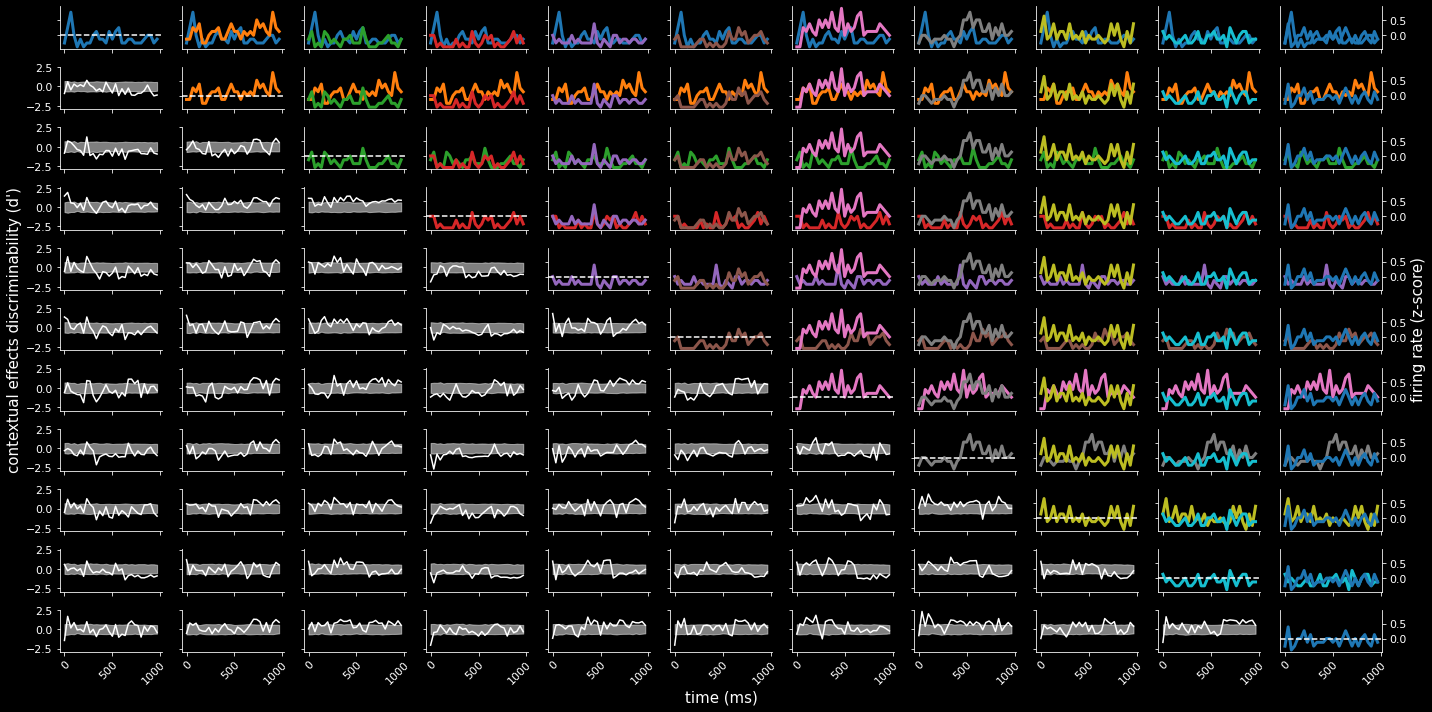

In [22]:
dprime, shuff_dprime_quantiles, goodcells, var_capt = dPCA_dprimes_real(site, **expt, meta=meta)
t =  np.linspace(0, dprime.shape[-1] / meta['raster_fs'], dprime.shape[-1], endpoint=False) * 1000

flipped_dprime, flipped_quantils = flip_dprimes(dprime, shuff_dprime_quantiles, flip='sum')
flipped_CI = flipped_quantils[alpha]

trialR, gc = load_raster_real(site, **expt, meta=meta, recache_rec=False)
trialR, R, _ = format_raster(trialR)

fig = grid_plot(site, trialR, dprime, flipped_CI, 7)
fig.set_size_inches(20, 10)

### example dprime for simulated data

[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=envelope
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/316/TNC013a_32a6808c9aba7761e39b0f7bfb24e690c1b36963.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC013/TNC013a09_p_CPN.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC013/TNC013a09_p_CPN.evp


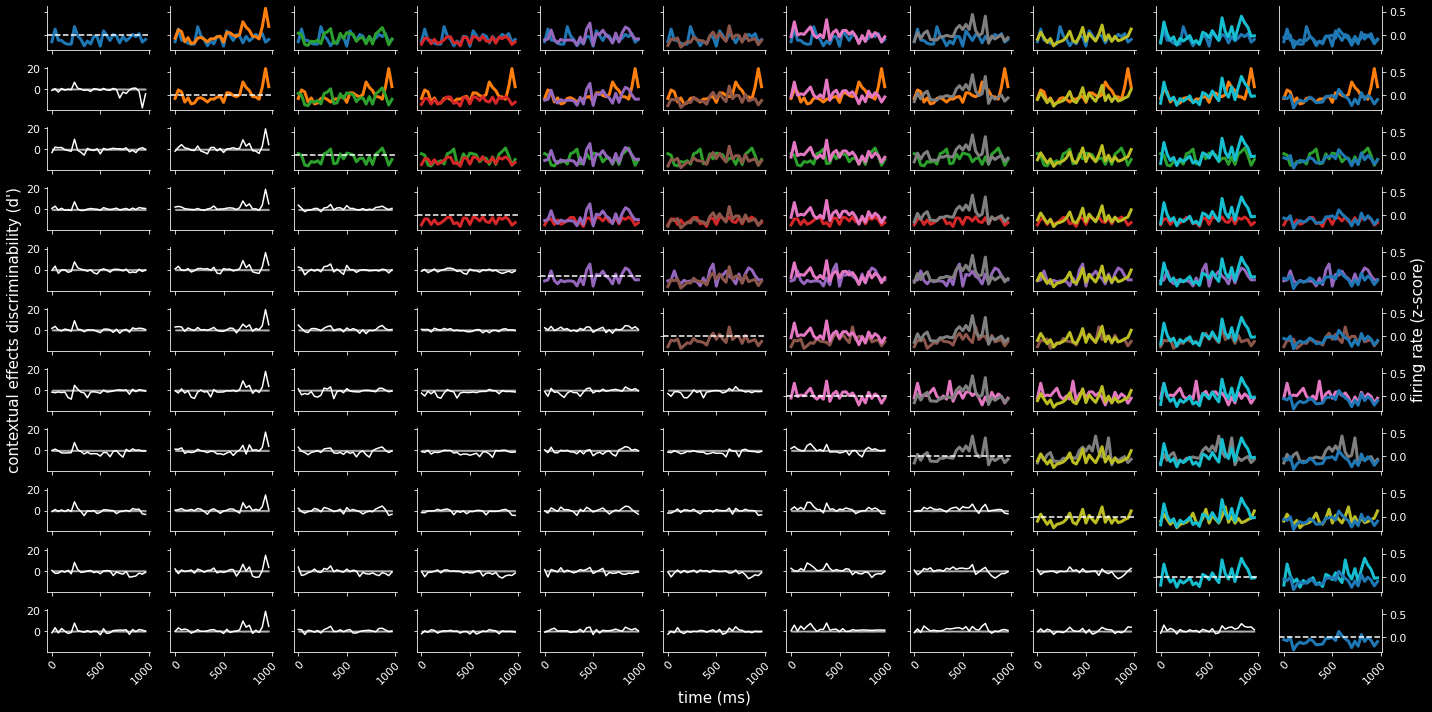

In [20]:
dprime_sim, shuff_dprime_quantiles_sim, goodcells, var_capt_sim = dPCA_dprimes_sim(site, **expt, meta=meta)
t =  np.linspace(0, dprime_sim.shape[-1] / meta['raster_fs'], dprime_sim.shape[-1], endpoint=False) * 1000

flipped_dprime, flipped_quantils = flip_dprimes(dprime_sim, shuff_dprime_quantiles_sim, flip='sum')
flipped_CI = flipped_quantils[alpha]

trialR_sim, gc = load_raster_sim(site, **expt, meta=meta, recache_rec=False)
trialR_sim, R_sim, _ = format_raster(trialR_sim)

fig = grid_plot(site, trialR_sim, dprime_sim, flipped_CI, 7)
fig.set_size_inches(20, 10)

something is fishi: either the homogenized context effects take away all variation in probe responses, leading to realy
high dprime values, or something more obscure is happening

in any case, before jumping into the dprimes for dPCA projections
I should get some idea of the behaviour for individual neurons

## compares example neuron from simulated and real data.

### example dprimes for real data

[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=envelope
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/316/TNC013a_32a6808c9aba7761e39b0f7bfb24e690c1b36963.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC013/TNC013a09_p_CPN.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC013/TNC013a09_p_CPN.evp


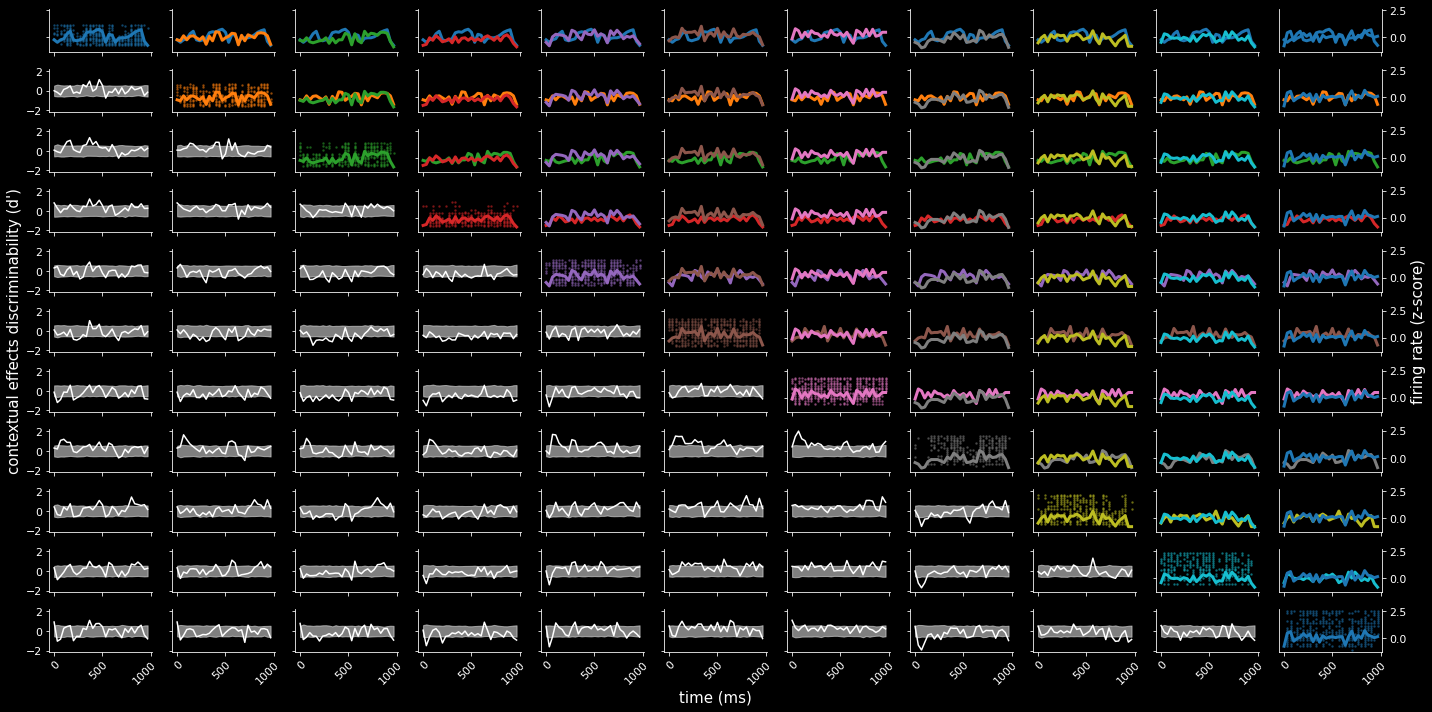

In [27]:
dprime, shuff_dprime_quantiles, goodcells, var_capt = cell_dprimes_real(site, **expt, meta=meta)
t =  np.linspace(0, dprime.shape[-1] / meta['raster_fs'], dprime.shape[-1], endpoint=False) * 1000

flipped_dprime, flipped_quantils = flip_dprimes(dprime, shuff_dprime_quantiles, flip='sum')
flipped_CI = flipped_quantils[alpha]

trialR, gc = load_raster_real(site, **expt, meta=meta, recache_rec=False)
trialR, R, _ = format_raster(trialR)

fig = grid_plot(cell, trialR, dprime, flipped_CI, 7)
fig.set_size_inches(20, 10)

### example dprime for simulated data

[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=envelope
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/316/TNC013a_32a6808c9aba7761e39b0f7bfb24e690c1b36963.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC013/TNC013a09_p_CPN.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC013/TNC013a09_p_CPN.evp


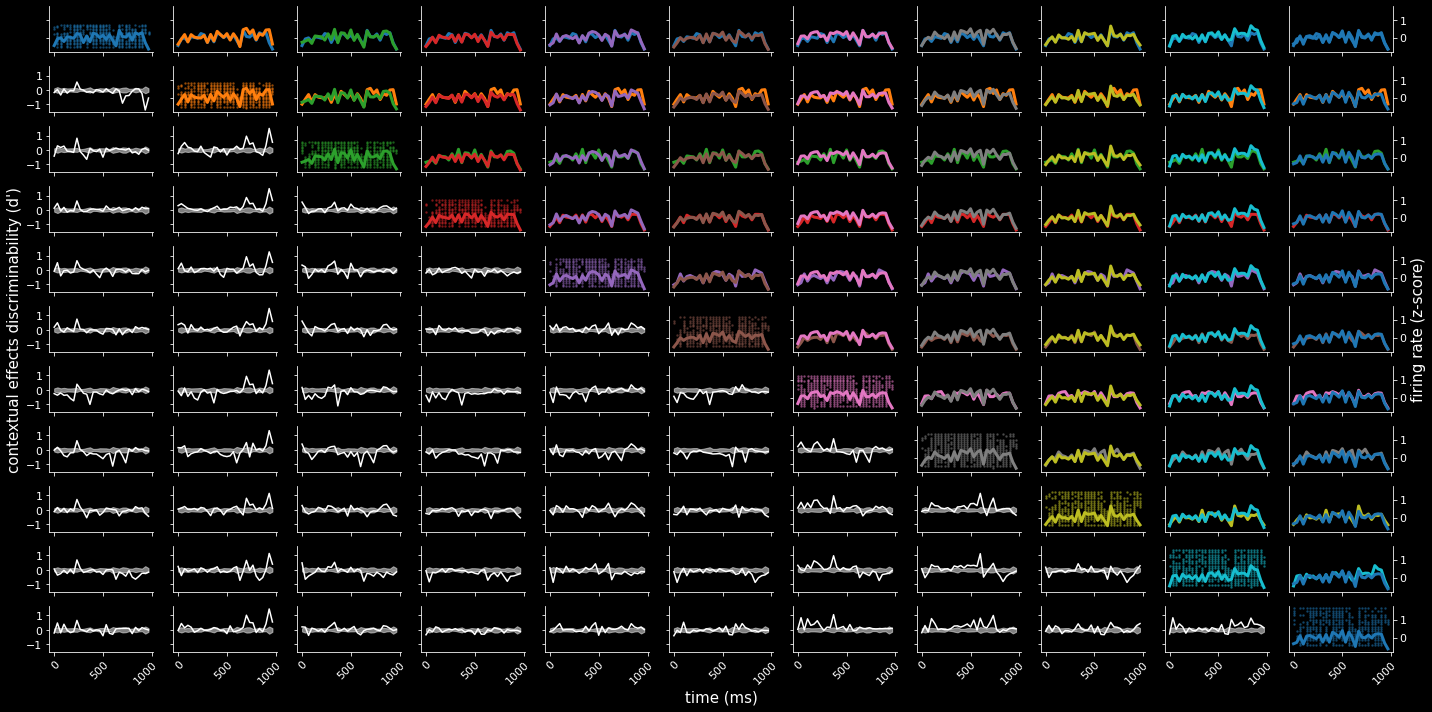

In [28]:
dprime_sim, shuff_dprime_quantiles_sim, goodcells, var_capt_sim = cell_dprimes_sim(site, **expt, meta=meta)
t =  np.linspace(0, dprime_sim.shape[-1] / meta['raster_fs'], dprime_sim.shape[-1], endpoint=False) * 1000

flipped_dprime, flipped_quantils = flip_dprimes(dprime_sim, shuff_dprime_quantiles_sim, flip='sum')
flipped_CI = flipped_quantils[alpha]

trialR_sim, gc = load_raster_sim(site, **expt, meta=meta, recache_rec=False)
trialR_sim, R_sim, _ = format_raster(trialR_sim)

fig = grid_plot(cell, trialR_sim, dprime_sim, flipped_CI, 7)
fig.set_size_inches(20, 10)


